In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

Зчитування даних

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Розмір:

In [4]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

Інформація про датасети

In [5]:
train_data.info(), print(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null floa

(None, None, None)

Перевірка наявності не вказаних, пропущених даних

In [6]:
train_data.isna().any(), print(), test_data.isna().any()

(PassengerId    False
 Survived       False
 Pclass         False
 Name           False
 Sex            False
 Age             True
 SibSp          False
 Parch          False
 Ticket         False
 Fare           False
 Cabin           True
 Embarked        True
 dtype: bool,
 None,
 PassengerId    False
 Pclass         False
 Name           False
 Sex            False
 Age             True
 SibSp          False
 Parch          False
 Ticket         False
 Fare            True
 Cabin           True
 Embarked       False
 dtype: bool)

In [7]:
def count_na(df, columns):  
    counts = [(df[col].isna() == 1).sum() for col in columns]
    print([(columns[i], counts[i]) for i in range(len(columns))])

In [8]:
count_na(train_data, ['Age', 'Cabin', 'Embarked'])
count_na(test_data, ['Age', 'Cabin', 'Fare'])

[('Age', 177), ('Cabin', 687), ('Embarked', 2)]
[('Age', 86), ('Cabin', 327), ('Fare', 1)]


In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train_data.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Farrell, Mr. James",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


In [11]:
train_data[['Sex', 'Survived']].groupby('Sex').mean().sort_values('Survived', ascending = False)

,Survived
Sex,
female,0.742038
male,0.188908


In [12]:
train_data[['Age', 'Survived']].groupby('Age').mean().sort_values('Survived', ascending = False)

,Survived
Age,
0.42,1.0
5.00,1.0
63.00,1.0
53.00,1.0
0.67,1.0
...,...
28.50,0.0
36.50,0.0
34.50,0.0


/home/oksana/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/oksana/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


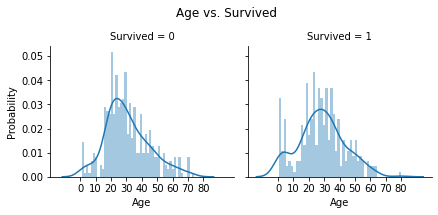

In [13]:
ticks = [i for i in np.arange(0, 90, 10)]
g = sns.FacetGrid(train_data, col = 'Survived')
g = g.map(sns.distplot, 'Age', bins = 50)
g.set(xticks = ticks)
g.set_axis_labels('Age','Probability')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Age vs. Survived")
plt.show()

In [14]:
train_data[['Pclass', 'Survived']].groupby('Pclass').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


/home/oksana/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


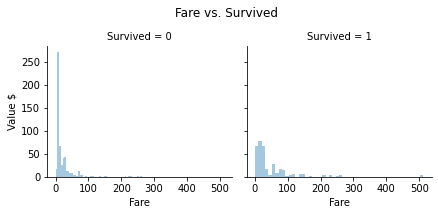

In [15]:
g = sns.FacetGrid(train_data, col = 'Survived')
g = g.map(sns.distplot, 'Fare', bins = 50, kde = False)
g.set_axis_labels('Fare','Value $')
g.fig.subplots_adjust(top = 0.8)
g.fig.suptitle("Fare vs. Survived")
plt.show()

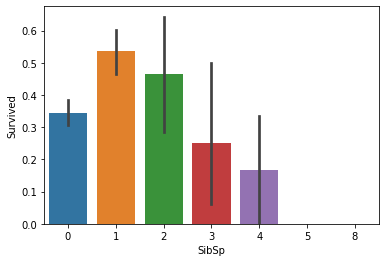

In [16]:
sns.barplot(x = train_data['SibSp'], y = train_data['Survived'])
plt.show()

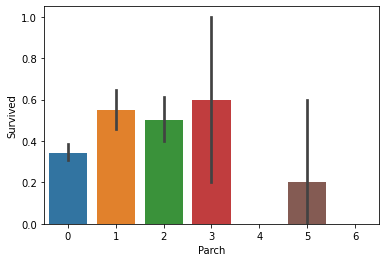

In [17]:
sns.barplot(x = train_data['Parch'], y = train_data['Survived'])
plt.show()

In [19]:
train_data[['Embarked', 'Survived']].groupby('Embarked').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [20]:
train_data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool